In [1]:
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [30]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
#print(dftrain.head())#prints the first five rows of our datasets from all the columns from dftrain
y_train = dftrain.pop('survived')#removes the column survived from dftrain and stores it in variable y_train, to separate the output to the input
y_eval = dfeval.pop('survived')#same thing for the testing dataset as well
#print(dftrain.loc[0],y_train.loc[0]) #.loc[n] is to find a specific row which is n in our data frame
print(dftrain["age"])#prints the column age only

0      22.0
1      38.0
2      26.0
3      35.0
4      28.0
       ... 
622    28.0
623    25.0
624    19.0
625    28.0
626    32.0
Name: age, Length: 627, dtype: float64


Now we gonna use graph representation for visual representation

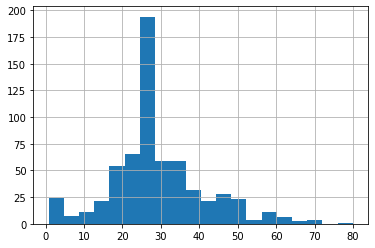

In [14]:
dftrain.age.hist(bins=20) #using a histograph to show us the age distribution

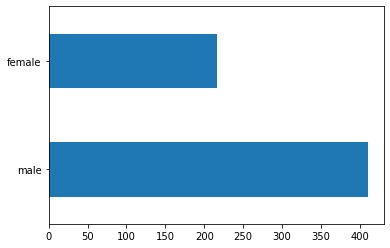

In [15]:
dftrain.sex.value_counts().plot(kind='barh')

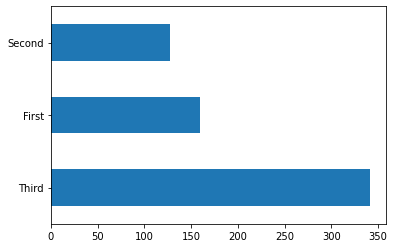

In [16]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

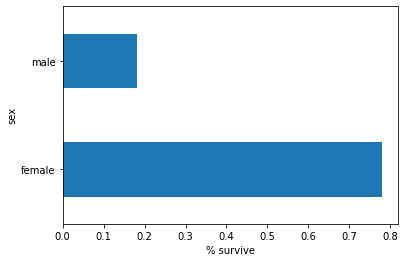

In [17]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

After analyzing this information, we should notice the following:
- Most passengers are in their 20's or 30's 
- Most passengers are male
- Most passengers are in "Third" class
- Females have a much higher chance of survival


### Training vs Testing Data
You may have noticed that we loaded **two different datasets** above. This is because when we train models, we need two sets of data: **training and testing**. 

The **training** data is what we feed to the model so that it can develop and learn. It is usually a much larger size than the testing data.

The **testing** data is what we use to evaulate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on to evaluate it. Can you think of why this is?

Well, the point of our model is to be able to make predictions on NEW data, data that we have never seen before. If we simply test the model on the data that it has already seen we cannot measure its accuracy accuratly. We can't be sure that the model hasn't simply memorized our training data. This is why we need our testing and training data to be seperate.




In [20]:
dfeval.shape #as you can see from the result we can tell that we have 264 entries to test our model with

(264, 9)

###Feature Columns
In our dataset we have two different kinds of information: **Categorical and Numeric**

Our **categorical data** is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2). 

Fortunately for us TensorFlow has some tools to help!


In [29]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone'] #colums in our dataset that contain data with non-numeric data
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []  #create a blank list which will store our different feature columns
for feature_name in CATEGORICAL_COLUMNS: #we loop through each feature name in the categorical columns
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) 
  #just adding to the feature_column list, remember you need to make feature columns for linear regression
  #will create a column, in the form of a numpy array kind of , that has the feature_name then all the different vocabulary associated with it 
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
  #for the numeric columns we just get the feature name and get the data type and create the column 

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

The Training Process

So, we are almost done preparing our dataset and I feel as though it's a good time to explain how our model is trained. Specifically, how input data is fed to our model.
For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of epochs.
An epoch is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.
Ex. if we have 10 ephocs, our model will see the same dataset 10 times.
Since we need to feed our data in batches and multiple times, we need to create something called an input function. The input function simply defines how our dataset will be converted into batches at each epoch.


###Input Function
The TensorFlow model we are going to use requires that the data we pass it comes in as a ```tf.data.Dataset``` object. This means we must create a *input function* that can convert our current pandas dataframe into that object. 

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandble, but you may want to refer to the documentation for a detailed explination of each method.

In [38]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  # data_df(pandas data frame), label_df(our labeled data frame i.e y_train y_eval),num_epochs(how many number of epochs we are going to do),shuffle
  #(which are we going to shuffle our data and mix before we pass it to the model),batch_size (means how many elements are we going to give to that model)
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle: #shuffle is true we shuffle our dataset 
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # this function makes an input function and returns the function object to wherever we call it from

train_input_fn = make_input_fn(dftrain, y_train,num_epochs=10, shuffle=True, batch_size=32)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False, batch_size=32) # 1 epochs and no shuffling because we are training it and we passing the evaluation dataset

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)#to use a linear estimator to utilize the linear regression algorithm.
# We create a linear estimtor by passing the feature columns we created earlier which defines what we should expect from our input data
# We pass it to the .LinearClassifier from the .estimator module and that creates the model for us 
# All we doing is creating an estimator which most of the core learning algorithms use  

linear_est.train(train_input_fn)  # we pass the train_input_fn, and this will use the function to grab data the we need and train the model
result = linear_est.evaluate(eval_input_fn)  # the result is evaluate rather than train, it is stored in the variable so that we look at it 

clear_output()  # clears consoke output, because there will be some output while we train
print(result['accuracy']) 
 # the result variable is simply a dict of stats about our model
 # we are referencing the accuracy from the result variable
 # notice that everytime we run the code the accuracy changes because our input data is being shuffled, so our model will make different predications
 # we got the accuracy by checking the predications made by the model vs the actual values of the dataset 
print(result)

0.7537879
{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8356596, 'auc_precision_recall': 0.78357255, 'average_loss': 0.4741711, 'label/mean': 0.375, 'loss': 0.46539715, 'precision': 0.67, 'prediction/mean': 0.38289112, 'recall': 0.67676765, 'global_step': 200}


In [46]:
#now we want to actually check the predictions we use a method called .predict
#now we pass the input function we used for the evaluation
#just like how we need to pass input function to train a model, we also do the same for predictions
result = list(linear_est.predict(eval_input_fn)) #we use a list because it is a generator object, meant to be looped through
#print(result) # we get dictionaries that represent each prediction since we iput like 267 entries of data so we will definetely get alot of dictionaries
#print(result[0]['probabilities'])# we get probabilities of survival and not surviving
print(dfeval.loc[2])
print(y_eval[2])#we want to see if the person survived or not
print(result[2]['probabilities'][1])# want to get the probability of surviving of a single person using these 2 print statements

sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
1
0.6964703


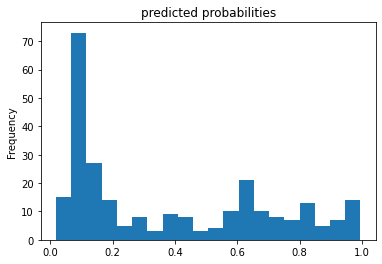

In [49]:
#now to graphically visualize the frequency of the predicted probabilities
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) #looping through the list

probs.plot(kind='hist', bins=20, title='predicted probabilities')